In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import numpy as np

In [3]:
file = open('cleaned.txt', 'r')
j = 0
points = []
for line in file.readlines()[84:112]:
    stripped = line.replace('\n', ' ').replace('(', ' ').replace(')', ' ').replace('[', ' ').replace(']', ' ').replace(':', ',').replace(' ', '').split(',')[2:]
    x = []
    y = []
    for i in range(int(len(stripped)/2)):
        a = float(stripped[2 * i])
        b = float(stripped[2 * i + 1])
        if (abs(a) < 3 and abs(b) < 3):
            x.append(a)
            y.append(b)
    points.append([x, y, [], 0, float(line.replace(' ', ',').split(',')[1])])

In [4]:
size = 30
min = -5
for k in range(len(points)):
    x = points[k][0]
    y = points[k][1]
    components = []
    count = 1
    grid = [[0 for i in range(size)] for j in range(size)]
    for i in range(len(x)):
        a = int(math.floor(x[i] / (6/size)) + size/2)
        b = int(math.floor(y[i] / (6/size)) + size/2)
        grid[a][b] -= 1
        if grid[a][b] == min:
            components.append((a, b))
    components.sort()
    for (a, b) in components:
        if grid[a][b] >= 0:
            continue
        label = []
        label.append((a, b))
        length = 0
        while length < len(label):
            (i, j) = label[length]
            if grid[i][j] >= 0:
                length += 1
                continue
            label.extend([(i - 1, j)] if i > 0 and grid[i - 1][j] <= 0 else [])
            label.extend([(i - 1, j - 1)] if i > 0 and j > 0 and grid[i - 1][j - 1] <= 0 else [])
            label.extend([(i - 1, j + 1)] if i > 0 and j < size - 1 and grid[i - 1][j + 1] <= 0 else [])
            label.extend([(i, j + 1)] if j < size - 1 and grid[i][j + 1] <= 0 else [])
            label.extend([(i, j - 1)] if j > 0 and grid[i][j - 1] <= 0 else [])
            label.extend([(i + 1, j)] if i < size - 1 and grid[i + 1][j] <= 0 else [])
            label.extend([(i + 1, j - 1)] if i < size - 1 and j > 0 and grid[i + 1][j-1] <= 0 else [])
            label.extend([(i + 1, j + 1)] if i < size - 1 and j < size - 1 and grid[i + 1][j + 1] <= 0 else [])
            grid[i][j] = count
            length += 1
        count += 1
    for i in range(len(x)):
        a = int(math.floor(x[i] / (6/size)) + size/2)
        b = int(math.floor(y[i] / (6/size)) + size/2)
        points[k][2].append(grid[a][b])
    points[k][3] = count - 1

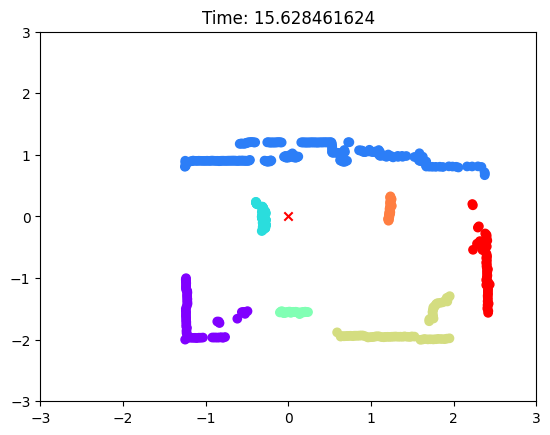

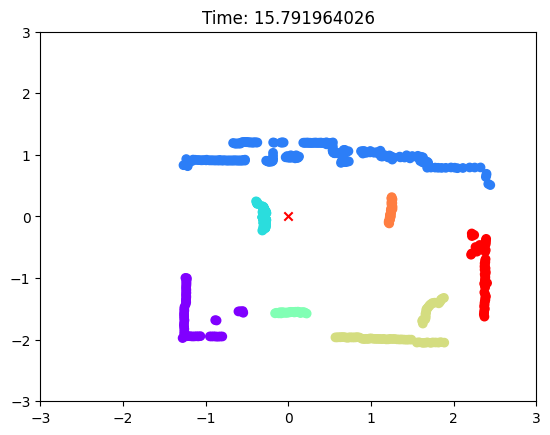

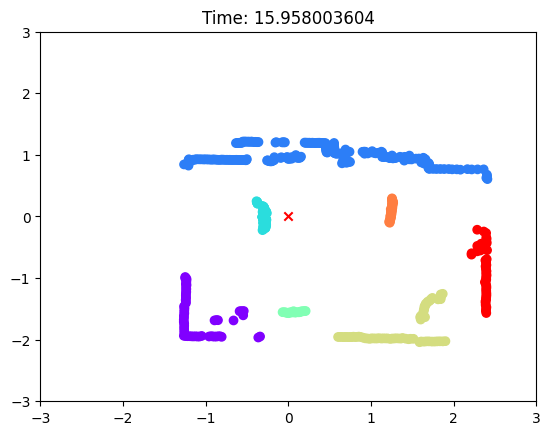

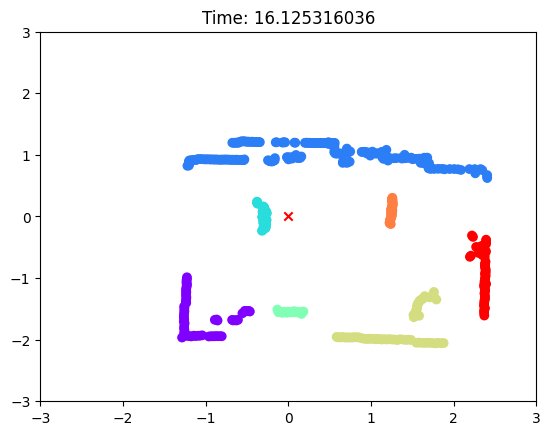

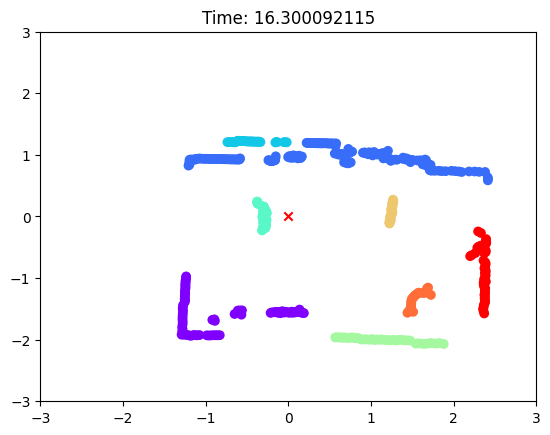

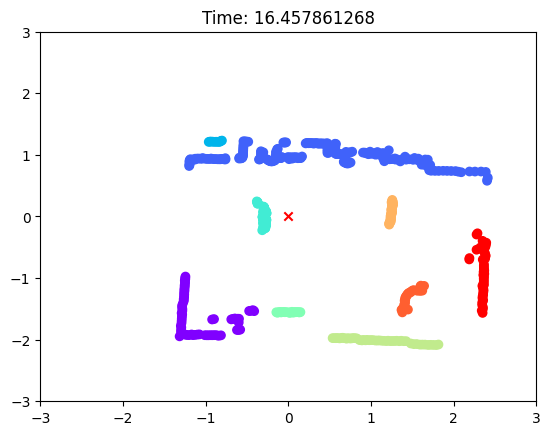

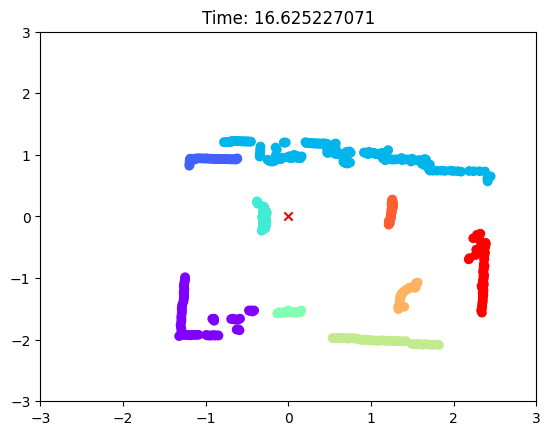

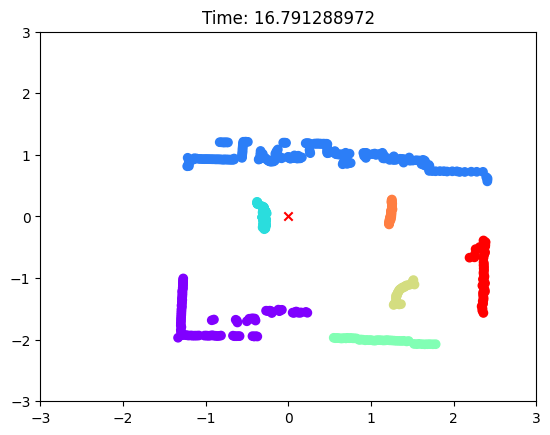

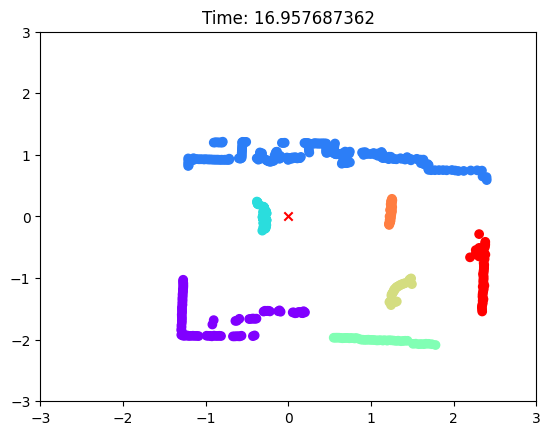

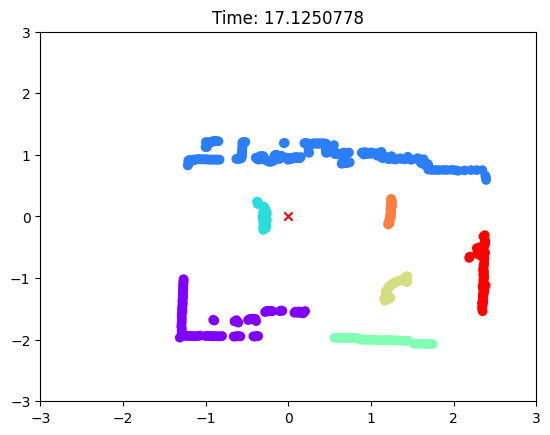

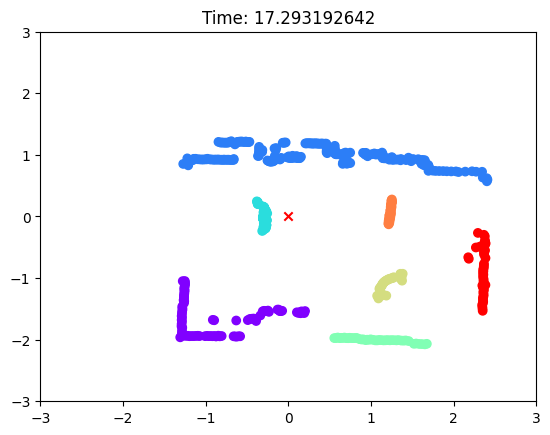

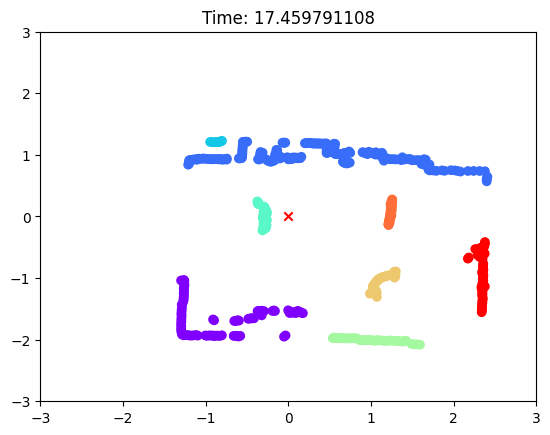

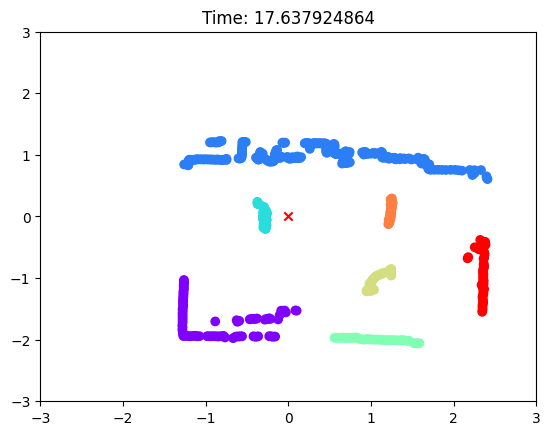

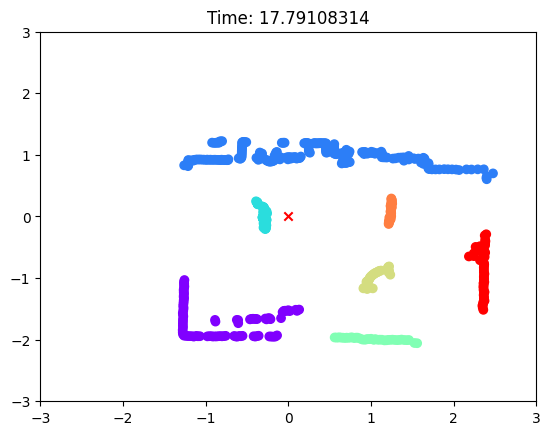

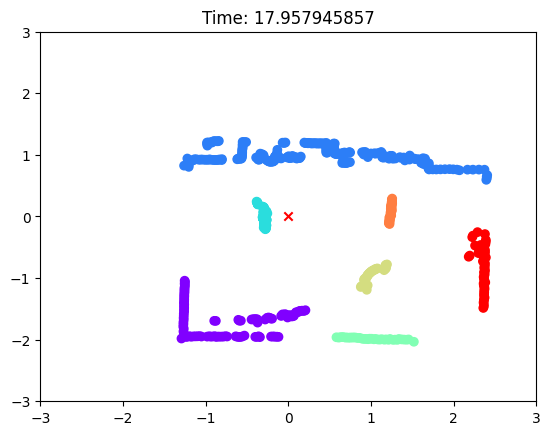

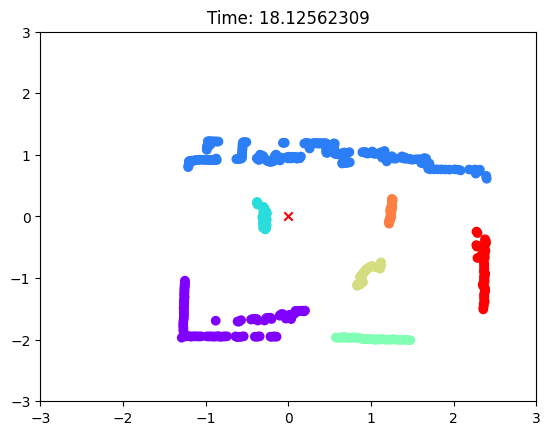

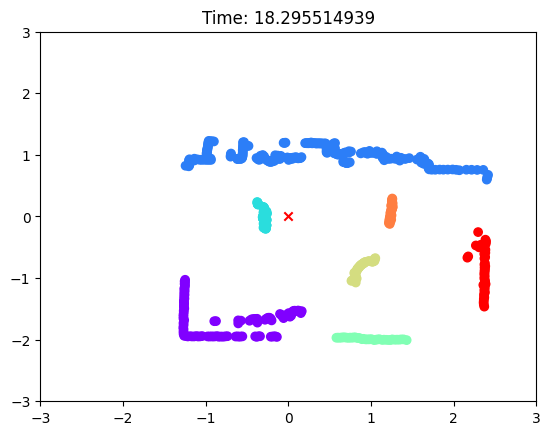

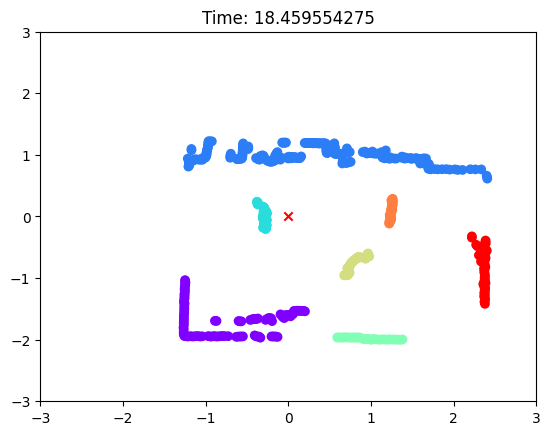

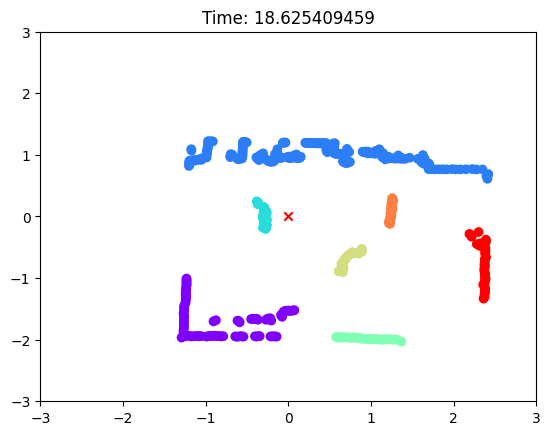

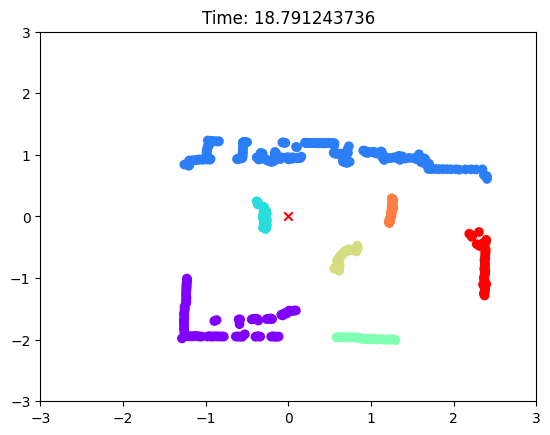

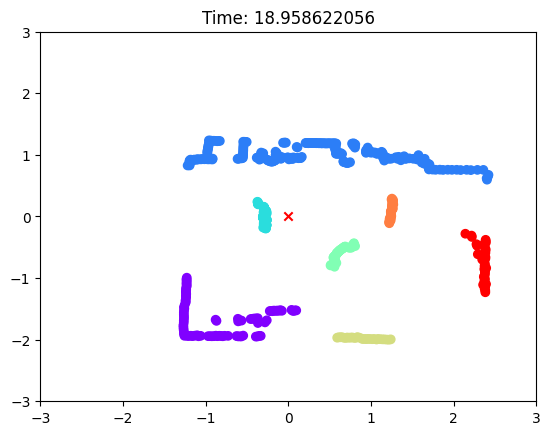

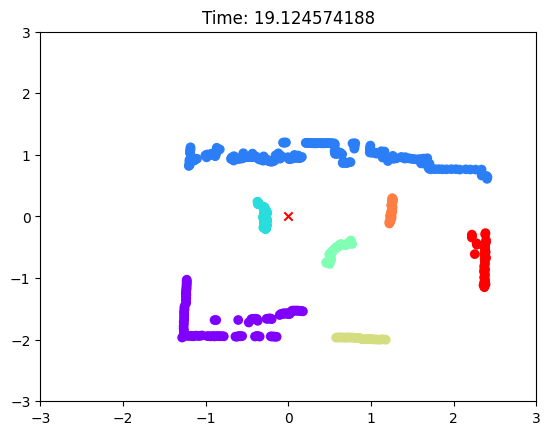

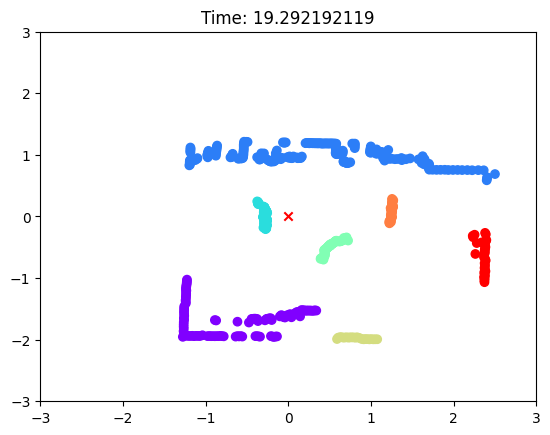

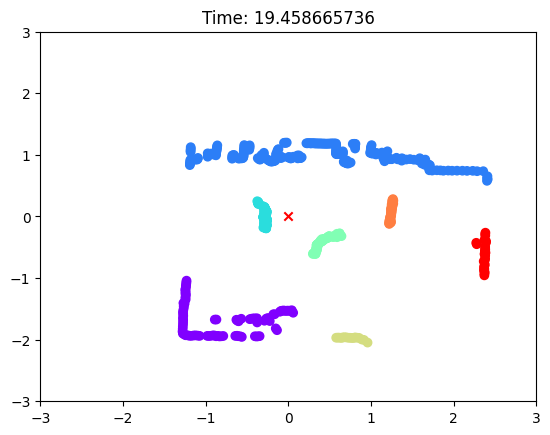

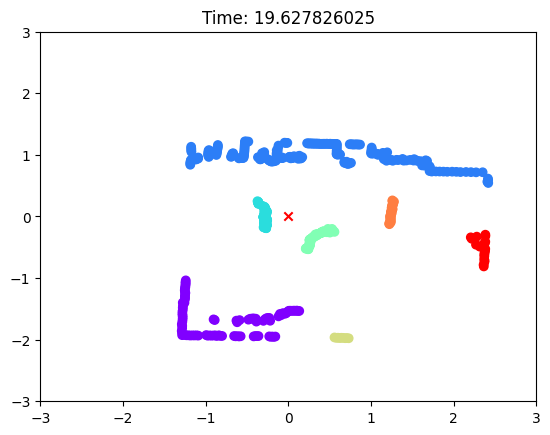

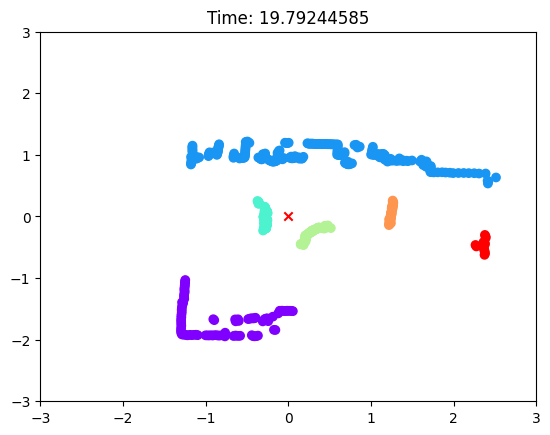

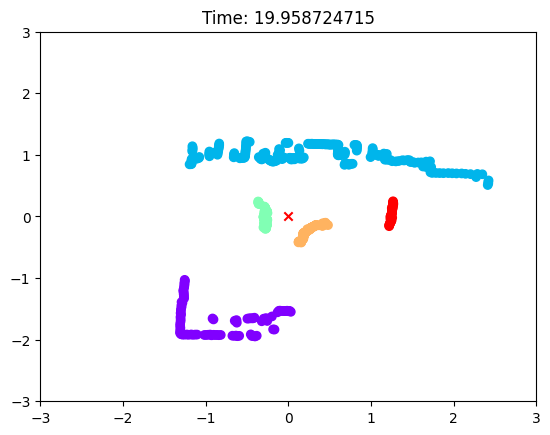

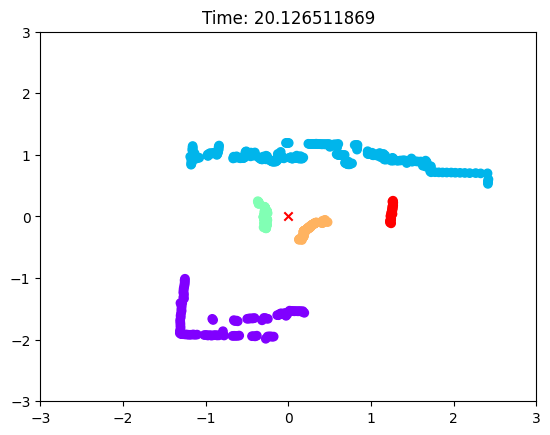

In [5]:
for (x, y, labels, count, time) in points:
    colors = []
    color_options = cm.rainbow(np.linspace(0, 1, count))
    for i in range(len(x)):
        if labels[i] <= 0:
            colors.append("white")
        else:
            colors.append(color_options[labels[i] - 1])
    plt.scatter(x, y,color=colors)
    plt.scatter(0, 0, c="red", marker='x')
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.title("Time: " + str(time))
    plt.show()